In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, NumeralTickFormatter
from bokeh.transform import factor_cmap
from bokeh.palettes import Category10
from bokeh.io import output_notebook
import pytz
import ast
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import statistics
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
df = pd.read_csv('data_clean.csv')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12534 entries, 0 to 12533
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           12534 non-null  int64 
 1   node_id                      12534 non-null  object
 2   full_name                    12534 non-null  object
 3   owner                        12534 non-null  object
 4   description                  12534 non-null  object
 5   created_at                   12534 non-null  object
 6   updated_at                   12534 non-null  object
 7   pushed_at                    12534 non-null  object
 8   size                         12534 non-null  int64 
 9   language                     12534 non-null  object
 10  has_issues                   12534 non-null  bool  
 11  has_projects                 12534 non-null  bool  
 12  has_downloads                12534 non-null  bool  
 13  has_wiki                     12

In [48]:
print(df)

              id       node_id                                      full_name  \
0      443592401  R_kgDOGnCu0Q                               progfolio/elpaca   
1      443476254  R_kgDOGm7pHg                         MoserMichael/pyasmtool   
2      443522708  R_kgDOGm-elA                victoryhb/streamlit-option-menu   
3      443522851  R_kgDOGm-fIw                                yihong0618/2022   
4      443470021  R_kgDOGm7QxQ                           aicezam/SmartOnmyoji   
...          ...           ...                                            ...   
12529  654990945  R_kgDOJwpeYQ                            Byxs20/FlowAnalyzer   
12530  654902184  R_kgDOJwkDqA                      ConnectAI-E/Go-Midjourney   
12531  654827428  R_kgDOJwffpA  supershaneski/openai-api-function-call-sample   
12532  655021349  R_kgDOJwrVJQ                             itrewm/Snapp-prize   
12533  654989401  R_kgDOJwpYWQ               zodiacon/winnativeapibooksamples   

                           

### repo

In [49]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
df['pushed_at'] = pd.to_datetime(df['pushed_at'])

In [50]:
df['month'] = df['created_at'].dt.month
projects_by_month = df.groupby('month')['id'].count()

In [51]:
# Création d'un DataFrame avec le nombre de projets créés par mois
df_projects_by_month = projects_by_month.reset_index()
df_projects_by_month.columns = ['Month', 'Number of Projects Created']

# Création du graphique en ligne à l'aide de Plotly
fig = px.line(df_projects_by_month, x='Month', y='Number of Projects Created', markers=True)

# Personnalisation de la mise en page du graphique
fig.update_layout(
    title='Tendances de la création de projets par mois',
    xaxis_title='Mois',
    yaxis_title='Number of Projects Created',
    xaxis={'type': 'category'},
    yaxis={'gridcolor': 'lightgray'},
    hovermode='x',
    legend={'orientation': 'h', 'y': -0.2},)

fig.show()

In [52]:
# Créer un DataFrame avec la taille moyenne des projets par mois
avg_size_by_month = df.groupby('month')['size'].mean()
df_avg_size_by_month = avg_size_by_month.reset_index()
df_avg_size_by_month.columns = ['Month', 'Average Project Size']

# Créer le graphique en ligne en utilisant Plotly
fig = px.line(df_avg_size_by_month, x='Month', y='Average Project Size', markers=True)

# Personnaliser la mise en page du graphique
fig.update_layout(
    title='Tendances de la taille moyenne des projets par mois',
    xaxis_title='Mois',
    yaxis_title='Taille moyenne du projet',
    xaxis={'type': 'category'},
    yaxis={'gridcolor': 'lightgray'},
    hovermode='x',
    legend={'orientation': 'h', 'y': -0.2},)
fig.show()

In [53]:
projects_updated_by_month = df.groupby('month')['updated_at'].count()
projects_pushed_by_month = df.groupby('month')['pushed_at'].count()

# Create a figure object
fig = go.Figure()

# Add the line trace for project updates
fig.add_trace(go.Scatter(
    x=projects_updated_by_month.index,
    y=projects_updated_by_month.values,
    name='Projects Updated',
    mode='lines',
    line=dict(color='blue')
))

# Add the line trace for project pushes
fig.add_trace(go.Scatter(
    x=projects_pushed_by_month.index,
    y=projects_pushed_by_month.values,
    name='Projects Pushed',
    mode='lines',
    line=dict(color='green')
))

# Customize the chart layout
fig.update_layout(
    title='Trends in Project Updates and Pushes by Month',
    xaxis_title='Month',
    yaxis_title='Number of Projects',
    xaxis={'type': 'category'},
    yaxis={'gridcolor': 'lightgray'},
    hovermode='x',
    legend={'orientation': 'h', 'y': -0.2},
)

# Show the chart
fig.show()


In [54]:
# Extraire l'année et le mois de la colonne 'created_at'
df['year_month'] = df['created_at'].dt.to_period('M')

# Regrouper les données par année et mois et calculer le nombre médian d'étoiles (stars), de forks et de watchers
median_stars_by_month = df.groupby('year_month')['star'].median()
median_forks_by_month = df.groupby('year_month')['forks'].median()
median_watchers_by_month = df.groupby('year_month')['watchers'].median()

# Configurer la figure
output_notebook()
p = figure(x_range=median_stars_by_month.index.astype(str).tolist(), plot_width=800, plot_height=400,
           title='Popularité des projets au fil du temps', x_axis_label='Année-Mois', y_axis_label='Nombre médian')

# Tracer le nombre médian d'étoiles, de forks et de watchers au fil du temps
p.line(median_stars_by_month.index.astype(str).tolist(), median_stars_by_month.values, legend_label='Étoiles', line_color='blue')
p.line(median_forks_by_month.index.astype(str).tolist(), median_forks_by_month.values, legend_label='Forks', line_color='green')
p.line(median_watchers_by_month.index.astype(str).tolist(), median_watchers_by_month.values, legend_label='Watchers', line_color='red')

# Formater les étiquettes des ticks de l'axe y en nombres entiers
p.yaxis.formatter = NumeralTickFormatter(format="0")

# Faire pivoter les étiquettes des ticks de l'axe x
p.xaxis.major_label_orientation = 45

# Afficher le graphique
show(p)


C:\Users\amine\AppData\Local\Temp\ipykernel_13824\2131798895.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



Loading BokehJS ...

In [55]:
# Analyze frequency of updates
df['update_frequency'] = (df['updated_at'] - df['created_at']).dt.days

# Analyze activity by pushes
df['push_activity'] = (df['updated_at'] - df['pushed_at']).dt.days

print("Frequency of Updates:")
print(df['update_frequency'].describe().round(2))
print()

print("Activity by Pushes:")
print(df['push_activity'].describe().round(2))


Frequency of Updates:
count    12534.00
mean       265.61
std        166.61
min          0.00
25%        113.00
50%        260.00
75%        416.00
max        545.00
Name: update_frequency, dtype: float64

Activity by Pushes:
count    12534.00
mean        95.46
std        124.67
min       -218.00
25%          6.00
50%         44.00
75%        138.00
max        539.00
Name: push_activity, dtype: float64


In [56]:
# Convert the string representation to lists
df['contributions'] = df['contributions'].apply(lambda x: ast.literal_eval(x))

In [57]:
df['total_contributions'] = df['contributions'].apply(lambda x: sum(x))
df['num_contributors'] = df['contributions'].apply(lambda x: len(x))

In [58]:
# Assuming your DataFrame is called df
top_20_repos = df.nlargest(20, 'total_contributions')

sorted_top_20 = top_20_repos[['id', 'full_name', 'size', 'watchers', 'owner_type', 'language', 'total_contributions', 'num_contributors']].sort_values('total_contributions', ascending=False)

sorted_top_20

id                               full_name   size  watchers  \
5684   514094141                   arielherself/espresso   7774         4   
703    447854129                  proxmox/proxmox-backup  14796         4   
10086  623517062                     vfarid/cf-clean-ips  18784        12   
3048   480414087                          fn2006/PollyMC  27422         8   
7980   586914715                        buroa/k8s-gitops   6134         3   
2821   478533432                       szinn/k8s-homelab   5440         3   
2473   471053210  perpetual-protocol/perp-curie-contract  19271         3   
312    445395904                   NickvisionApps/Denaro  16937         9   
3761   491554423                        Gh0stBlade/KAIN2   6339         7   
3574   490081196       matterandvoid-space/subscriptions  12810         2   
7118   564111672                           hshq/harelang   5542         3   
5930   540287012                 team-aliens/DMS-Android   4919         0   
3450   489350934         aurimas13/Solutions-To-Problems   2531         7   
414    446093093    elementary-data/dbt-data-reliability   6855         3   
841    448974533                     electric-sql/vaxine  19272         9   
3914   492414895                       ueokande/vimmatic   6837         5   
1283   457523927                robocode-dev/tank-royale  15271         7   
2302   469589577                     VolcanicArts/VRCOSC   5776         4   
8760   599162152                           berty/weshnet   9611         9   
900    454812611                    Librum-Reader/Librum  27478        14   

         owner_type    language  total_contributions  num_contributors  
5684           User      Python                12144                 1  
703    Organization        Rust                 6696                13  
10086          User      Python                 6624                 2  
3048           User         C++                 5356                30  
7980           User        YAML                 5265                 5  
2821           User         HCL                 4188                 5  
2473   Organization  TypeScript                 3327                18  
312    Organization          C#                 3065                28  
3761           User           C                 2929                 5  
3574   Organization     Clojure                 2628                30  
7118           User    Makefile                 2518                30  
5930   Organization      Kotlin                 2513                 7  
3450           User      Python                 2443                 1  
414    Organization      Python                 2258                28  
841    Organization      Erlang                 2210                30  
3914           User  TypeScript                 2203                30  
1283   Organization      Kotlin                 2164                 5  
2302           User          C#                 2050                 3  
8760   Organization          Go                 2046                30  
900    Organization         C++                 1943                 2

In [59]:
# Assuming your sorted DataFrame is called sorted_top_20
repos = sorted_top_20['full_name']
contributions = sorted_top_20['total_contributions']
num_contributors = sorted_top_20['num_contributors']

# Calculate statistics
mean_contributions = statistics.mean(contributions)
median_contributions = statistics.median(contributions)

# Create a bar graph with ascending colors
fig = px.bar(sorted_top_20, x=contributions, y=repos, orientation='h',
             text=num_contributors, labels={'x': 'Total Contributions', 'y': 'Repository'},
             title='Top 20 Repositories by Total Contributions',
             color=contributions, color_continuous_scale='viridis', range_color=[min(contributions), max(contributions)])

fig.update_traces(textposition='outside')

# Add statistics annotations
fig.add_annotation(x=mean_contributions, y=len(repos) + 1,
                   text=f'Mean: {mean_contributions:.2f}', showarrow=False)
fig.add_annotation(x=median_contributions, y=len(repos) + 2,
                   text=f'Median: {median_contributions:.2f}', showarrow=False)

fig.show()


#### statistiques descriptives

In [60]:
selected_columns = ['size', 'open_issues', 'star', 'watchers', 'forks']
stats = df[selected_columns].describe().round(2)
stats

size  open_issues      star  watchers     forks
count  12534.00     12534.00  12534.00  12534.00  12534.00
mean    3192.43         2.61     89.95      4.03     11.19
std     5471.59         3.71     66.44      2.89     12.00
min        1.00         0.00     10.00      0.00      0.00
25%      133.00         0.00     46.00      2.00      3.00
50%      692.00         1.00     67.00      3.00      7.00
75%     3504.25         4.00    113.00      5.00     15.00
max    30626.00        20.00    384.00     17.00     68.00

### size

In [61]:
# Analyse de distribution - Histogramme
fig = px.histogram(df, x='size', nbins=20, color_discrete_sequence=['#008080'])
fig.update_layout(
    xaxis_title='Taille',
    yaxis_title='Fréquence',
    title='Distribution des tailles de projet',
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.show()

# Analyse de séries temporelles - Graphique linéaire
df['created_at'] = pd.to_datetime(df['created_at'])  # Convert to datetime if necessary
df_sorted = df.sort_values('created_at')  # Sort by creation date
fig = px.line(df_sorted, x='created_at', y='size', color_discrete_sequence=['#800080'])
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Taille',
    title='Évolution des tailles de projet au fil du temps',
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.show()


In [62]:
# Définir les limites des intervalles et les étiquettes pour les catégories
bin_edges = [0, 500, 1000, 5000, float('inf')]
bin_labels = ['Petit', 'Moyen', 'Grand', 'Très grand']

# Créer une nouvelle colonne 'size_category' basée sur la colonne 'size'
df['size_category'] = pd.cut(df['size'], bins=bin_edges, labels=bin_labels, right=False)


In [63]:
# Compter le nombre d'occurrences de chaque catégorie dans la colonne 'size_category'
category_counts = df['size_category'].value_counts()

# Afficher le décompte des catégories
print(category_counts)


size_category
Petit         5640
Grand         3033
Très grand    2502
Moyen         1359
Name: count, dtype: int64


In [64]:
# Préparer les données
data = {
    'size_category': ['Small', 'Large', 'Very Large', 'Medium'],
    'count': [1900, 1181, 983, 536]
}

# Calculer le pourcentage pour chaque catégorie
total_count = sum(data['count'])
data['percentage'] = [count / total_count * 100 for count in data['count']]

# Créer un diagramme circulaire avec Plotly
fig = px.pie(data, values='count', names='size_category', 
             title='Catégories de taille des dépôts',
             labels={'count': 'Nombre', 'size_category': 'Catégorie de taille'},
             hover_data=['percentage'], 
             hover_name='size_category',
             hole=0.4)

# Définir le format du pourcentage pour l'étiquette au survol
fig.update_traces(textinfo='percent+label')

# Afficher le graphique
fig.show()


#### open_issues

In [65]:
# Créer l'histogramme de la distribution des open_issues
fig = px.histogram(df, x='open_issues', nbins=20)

# Personnaliser les titres des axes et le titre du graphique
fig.update_layout(
    xaxis_title='Open Issues',
    yaxis_title='Fréquence',
    title='Distribution des Open Issues'
)

# Afficher le graphique
fig.show()


In [66]:
# Convertir la colonne "created_at" en datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Regrouper les données par date et compter le nombre de open_issues pour chaque date
trend_data = df.groupby(df['created_at'].dt.date)['open_issues'].count()

# Créer une figure Bokeh
output_notebook()  # Afficher le graphique dans Jupyter Notebook
p = figure(title='Analyse de tendance des Open Issues', x_axis_type='datetime', sizing_mode='stretch_both',
           background_fill_color='#f2f2f2', tools='hover')

# Tracer la ligne de tendance
p.line(trend_data.index, trend_data.values, line_width=2, color='#007bff', legend_label='Open Issues')
p.circle(trend_data.index, trend_data.values, size=6, color='#007bff', alpha=0.8, legend_label='Open Issues')

# Personnaliser le graphique
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Nombre de Open Issues'
p.xaxis.formatter.days = '%m/%d/%Y'  # Formater les étiquettes de l'axe x
p.yaxis.formatter = NumeralTickFormatter(format='0')  # Formater les étiquettes de l'axe y en entiers
p.legend.location = 'top_left'
p.legend.label_text_font_size = '12px'

# Appliquer des aspects esthétiques supplémentaires
p.toolbar.logo = None
p.grid.grid_line_alpha = 0.3 
p.border_fill_color = '#ffffff' 

# Afficher le graphique
show(p)


Loading BokehJS ...

In [67]:
category_counts = {}

# Define your keywords and corresponding categories
keywords = {
    'bug': 'Bug',
    'error': 'Error',
    'issue': 'Issue',
    'crash': 'Crash',
    'failure': 'Failure'
    # Add more keywords and categories as needed
}

for index, row in df.iterrows():
    description = row['description']
    
    if isinstance(description, float):  # Check if description is a float
        description = str(description)  # Convert float to string
    
    description = description.lower()
    
    category = 'Non_classé'
    for keyword, cat in keywords.items():
        if keyword in description:
            category = cat
            break
    
    # Count the occurrences of each category
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Display the result for each category
for category, count in category_counts.items():
    print(f"{category}: {count}")


Non_classé: 12383
Bug: 77
Error: 38
Issue: 20
Crash: 12
Failure: 4


In [68]:
import pandas as pd
import plotly.graph_objects as go

# Define the category counts
category_counts = {
    'Non_classé': 12744,
    'Bug': 73,
    'Error': 38,
    'Issue': 23,
    'Crash': 13,
    'Failure': 4
}

category_colors = {
    'Bug': 'lightblue',
    'Error': 'lightgreen',
    'Crash': 'lightyellow',
    'Failure': 'lightcoral'
}

default_color = 'gray'  # Define a default color for categories not in category_colors

# Create the DataFrame for category counts
df_counts = pd.DataFrame({'category': list(category_counts.keys()), 'count': list(category_counts.values())})

# Filter out the 'Non_classé' category
df_filtered = df_counts[df_counts['category'] != 'Non_classé']

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=df_filtered['category'],
    y=df_filtered['count'],
    marker_color=[category_colors.get(cat, default_color) for cat in df_filtered['category']]
)])

# Customize the layout
fig.update_layout(
    title='Category Counts for Problems',
    xaxis_title='Category',
    yaxis_title='Count',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font_color='black'
)

# Show the chart
fig.show()


#### watchers

In [69]:
# Analyse de la distribution - Histogramme des Watchers
fig_histogram = px.histogram(df, x='watchers', nbins=20)
fig_histogram.update_layout(
    xaxis_title='Nombre de Watchers',
    yaxis_title='Fréquence',
    title='Distribution des Watchers'
)
fig_histogram.show()

# Analyse de séries temporelles - Graphique en ligne des Watchers
df['created_at'] = pd.to_datetime(df['created_at'])  # Conversion en format datetime si nécessaire
df_sorted = df.sort_values('created_at')  # Trier par date de création
fig_line = px.line(df_sorted, x='created_at', y='watchers')
fig_line.update_layout(
    xaxis_title='Date',
    yaxis_title='Nombre de Watchers',
    title='Évolution des Watchers au fil du temps'
)
fig_line.show()


In [70]:
fig = px.scatter(df, x='star', y='watchers', title='Stars vs. Watchers')
fig.update_layout(xaxis_title='Star', yaxis_title='Watchers')
fig.show()


### corrélation

In [71]:
# Sélectionner les colonnes numériques pour l'analyse de corrélation
numerical_columns = ['size', 'open_issues', 'star', 'watchers', 'forks']
numerical_df = df[numerical_columns]

# Calculer la matrice de corrélation
correlation_matrix = numerical_df.corr()

# Afficher la matrice de corrélation
print(correlation_matrix)


                 size  open_issues      star  watchers     forks
size         1.000000     0.101724  0.070229  0.090120  0.077544
open_issues  0.101724     1.000000  0.236294  0.238169  0.188849
star         0.070229     0.236294  1.000000  0.368965  0.443737
watchers     0.090120     0.238169  0.368965  1.000000  0.283994
forks        0.077544     0.188849  0.443737  0.283994  1.000000


In [72]:
# Sélectionner les colonnes numériques pour l'analyse de corrélation
numerical_columns = ['size', 'open_issues', 'star', 'watchers', 'forks']
numerical_df = df[numerical_columns]

# Calculer la matrice de corrélation
correlation_matrix = numerical_df.corr()

# Créer une heatmap avec Plotly
fig = px.imshow(correlation_matrix,
                x=numerical_columns,
                y=numerical_columns,
                color_continuous_scale='RdBu',
                zmin=-1,
                zmax=1)

# Personnaliser la mise en page de la heatmap
fig.update_layout(
    title='Matrice de corrélation',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Variables'),
    width=600,
    height=500
)

# Afficher la heatmap
fig.show()


#### contributors

In [73]:
sorted_top_20

id                               full_name   size  watchers  \
5684   514094141                   arielherself/espresso   7774         4   
703    447854129                  proxmox/proxmox-backup  14796         4   
10086  623517062                     vfarid/cf-clean-ips  18784        12   
3048   480414087                          fn2006/PollyMC  27422         8   
7980   586914715                        buroa/k8s-gitops   6134         3   
2821   478533432                       szinn/k8s-homelab   5440         3   
2473   471053210  perpetual-protocol/perp-curie-contract  19271         3   
312    445395904                   NickvisionApps/Denaro  16937         9   
3761   491554423                        Gh0stBlade/KAIN2   6339         7   
3574   490081196       matterandvoid-space/subscriptions  12810         2   
7118   564111672                           hshq/harelang   5542         3   
5930   540287012                 team-aliens/DMS-Android   4919         0   
3450   489350934         aurimas13/Solutions-To-Problems   2531         7   
414    446093093    elementary-data/dbt-data-reliability   6855         3   
841    448974533                     electric-sql/vaxine  19272         9   
3914   492414895                       ueokande/vimmatic   6837         5   
1283   457523927                robocode-dev/tank-royale  15271         7   
2302   469589577                     VolcanicArts/VRCOSC   5776         4   
8760   599162152                           berty/weshnet   9611         9   
900    454812611                    Librum-Reader/Librum  27478        14   

         owner_type    language  total_contributions  num_contributors  
5684           User      Python                12144                 1  
703    Organization        Rust                 6696                13  
10086          User      Python                 6624                 2  
3048           User         C++                 5356                30  
7980           User        YAML                 5265                 5  
2821           User         HCL                 4188                 5  
2473   Organization  TypeScript                 3327                18  
312    Organization          C#                 3065                28  
3761           User           C                 2929                 5  
3574   Organization     Clojure                 2628                30  
7118           User    Makefile                 2518                30  
5930   Organization      Kotlin                 2513                 7  
3450           User      Python                 2443                 1  
414    Organization      Python                 2258                28  
841    Organization      Erlang                 2210                30  
3914           User  TypeScript                 2203                30  
1283   Organization      Kotlin                 2164                 5  
2302           User          C#                 2050                 3  
8760   Organization          Go                 2046                30  
900    Organization         C++                 1943                 2

In [74]:
df.columns

Index(['id', 'node_id', 'full_name', 'owner', 'description', 'created_at',
       'updated_at', 'pushed_at', 'size', 'language', 'has_issues',
       'has_projects', 'has_downloads', 'has_wiki', 'has_pages',
       'has_discussions', 'archived', 'disabled', 'is_template',
       'web_commit_signoff_required', 'topics', 'forks', 'open_issues', 'star',
       'default_branch', 'watchers', 'owner_name', 'owner_type',
       'language_name', 'language_percent', 'contributor_names',
       'contributor_ids', 'contributions', 'month', 'year_month',
       'update_frequency', 'push_activity', 'total_contributions',
       'num_contributors', 'size_category'],
      dtype='object')

In [75]:
df['contributor_names'] = df['contributor_names'].apply(lambda x: [] if x == '' else x)
df['contributions'] = df['contributions'].apply(lambda x: [] if x == '' else x)

df[['contributor_names', 'contributions']]

contributor_names    contributions
0      ['progfolio', 'ashton314', 'leotaku', 'lebenst...  [1364, 1, 1, 1]
1                       ['MoserMichael', 'mmoser-blaze']          [71, 1]
2                                ['victoryhb', 'fgdvir']          [20, 2]
3      ['yihong0618', 'Kilerd', 'hezhizhen', 'github-...   [972, 2, 1, 1]
4          ['aicezam', 'ImgBotApp', 'runhey', 'Sakaizd']   [196, 5, 4, 1]
...                                                  ...              ...
12529                                         ['Byxs20']             [16]
12530                        ['Leizhenpeng', 'DDMeaqua']           [7, 2]
12531                                                 []               []
12532                                                 []               []
12533                                                 []               []

[12534 rows x 2 columns]

In [76]:
# Assuming your original DataFrame is called df
# Clean the 'contributor_names' column
df['contributor_names'] = df['contributor_names'].apply(lambda x: [] if x == '' else ast.literal_eval(x))

# Explode the 'contributor_names' column
df_exploded = df.explode('contributor_names')

# Calculate total contributions for each contributor
df_exploded['total_contributions1'] = df_exploded['contributions'].apply(sum)

# Group by 'contributor_names' and calculate the sum of 'total_contributions'
top_contributors = df_exploded.groupby('contributor_names')['total_contributions'].sum().reset_index()

# Sort the DataFrame by 'total_contributions' in descending order
top_contributors = top_contributors.sort_values(by='total_contributions', ascending=False).reset_index(drop=True)

# Print the top contributors
print(top_contributors.head(10))


      contributor_names  total_contributions
0       dependabot[bot]               163824
1         renovate[bot]                57159
2   github-actions[bot]                56741
3          renovate-bot                19901
4          actions-user                13677
5          arielherself                12144
6  allcontributors[bot]                 8305
7              kianmeng                 8178
8             ImgBotApp                 7698
9  semantic-release-bot                 7113


In [77]:
# Assuming you have the DataFrame 'top_contributors' with the top 10 contributors and their total contributions
top_10 = top_contributors.head(10)

# Sort the DataFrame by 'total_contributions' in descending order for color ordering
top_10 = top_10.sort_values(by='total_contributions', ascending=False)

# Create a bar chart with descending color
fig = px.bar(top_10, x='contributor_names', y='total_contributions',
             labels={'contributor_names': 'Contributor Names', 'total_contributions': 'Total Contributions'},
             title='Top 10 Contributors by Total Contributions',
             color='total_contributions', color_continuous_scale='viridis',
             template='plotly_white')

# Show the plot
fig.show()


In [78]:
thresholds = [0, 100, 500, 1000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High']

df['contribution_category'] = pd.cut(df['total_contributions'], bins=thresholds, labels=labels)

In [79]:
# Assuming your DataFrame is called df
fig = px.pie(df, names='contribution_category', title='Contributor Categories',
             labels={'contribution_category': 'Contribution Category'},
             template='plotly_white')

fig.update_traces(textposition='inside', textinfo='percent+label')

fig.show()


### langues

In [80]:
language_names = df['language_name']
language_percentages = df['language_percent']


In [81]:
language_frequencies = {}

for names, percentages in zip(language_names, language_percentages):
    for name, percentage in zip(names, percentages):
        if name in language_frequencies:
            language_frequencies[name] += percentage
        else:
            language_frequencies[name] = percentage


In [82]:
sorted_languages = sorted(language_frequencies.items(), key=lambda x: x[1], reverse=True)

In [83]:
df['language_name'] = df['language_name'].apply(ast.literal_eval)

In [84]:
df = df.explode('language_name')

In [85]:
projects_by_language = df['language_name'].value_counts()

In [86]:
non_language_programming = ['Makefile', 'Dockerfile', 'Jupyter Notebook', 'Batchfile', 'Procfile', 'Vim Script', 'Nix', 'GLSL', 'Emacs Lisp', 'Roff', 'NSIS', 'AutoHotkey', 'Gnuplot', 'Logos', 'Markdown', 'Lex', 'NASL', 'Rich Text Format', 'TeX', 'Racket', 'XS', 'Bicep', 'AppleScript', 'VBA', 'ASP.NET', 'CodeQL', 'Cap\'n Proto', 'ShaderLab', 'HLSL', 'Rebol', 'mcfunction', 'G-code', 'VHDL', 'SQL', 'AWK', 'PLpgSQL', 'ReScript', 'MDX', 'Verilog', 'POV-Ray SDL', 'Jasmin', 'Cypher', 'StringTemplate', 'POV-Ray SDL', 'WebAssembly', 'Portugol', 'RPC', 'AngelScript', 'ASN.1', 'POV-Ray SDL', 'Latte', 'Stan', 'Cypher Query Language', 'XS', 'Starlark']

In [87]:
filtered_df = df[~df['language_name'].apply(lambda x: any(keyword in x for keyword in non_language_programming))]

# Perform analysis on the filtered dataframe
# For example, count the occurrences of each programming language
language_counts = filtered_df['language_name'].explode().value_counts()

# Print the language counts
print(language_counts)


language_name
Python        4143
JavaScript    3340
Shell         2986
HTML          2313
TypeScript    2116
              ... 
M                1
Macaulay2        1
Dhall            1
Prolog           1
sed              1
Name: count, Length: 182, dtype: int64


In [88]:
# Sort the language counts in descending order
sorted_language_counts = language_counts.sort_values(ascending=False)

# Select the top 20 languages
top_20_languages = sorted_language_counts.head(20)

# Create a bar chart using Plotly
fig = px.bar(x=top_20_languages.index, y=top_20_languages.values)
fig.update_layout(
    xaxis_title='Programming Language',
    yaxis_title='Number of Occurrences',
    title='Top 20 Programming Languages by Occurrences (Excluding Non-language Programming)',
    xaxis_tickangle=-45
)
fig.show()


### relations

In [89]:
# Assuming you have the DataFrame 'df' with project details

# Choose a project for comparison
chosen_project = "jafarlihi/modreveal"

# Check if the chosen project exists in the DataFrame
if chosen_project in df['full_name'].values:
    # Get the index of the chosen project
    chosen_project_index = df[df['full_name'] == chosen_project].index[0]

    # Get the project descriptions for TF-IDF
    project_descriptions = df['description'].fillna('')  # Fill any NaN values with empty strings

    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the TF-IDF vectorizer on project descriptions
    tfidf_matrix = vectorizer.fit_transform(project_descriptions)

    # Calculate cosine similarity scores for the chosen project
    cosine_similarities = cosine_similarity(tfidf_matrix[chosen_project_index].reshape(1, -1), tfidf_matrix).flatten()

    # Sort projects based on similarity scores
    similar_projects_indices = cosine_similarities.argsort()[::-1][1:]  # Exclude the chosen project itself

    # Check if the indices are valid and present in the DataFrame
    valid_indices = df.index.isin(similar_projects_indices)
    top_similar_projects = df.loc[valid_indices, 'full_name'].head(5)

    # Print the top similar projects
    print(f"Top 5 similar projects to {chosen_project}:")
    for i, project in enumerate(top_similar_projects, start=1):
        print(f"{i}. {project}")
else:
    print(f"Chosen project '{chosen_project}' not found in the DataFrame.")


Top 5 similar projects to jafarlihi/modreveal:
1. progfolio/elpaca
2. progfolio/elpaca
3. progfolio/elpaca
4. progfolio/elpaca
5. MoserMichael/pyasmtool


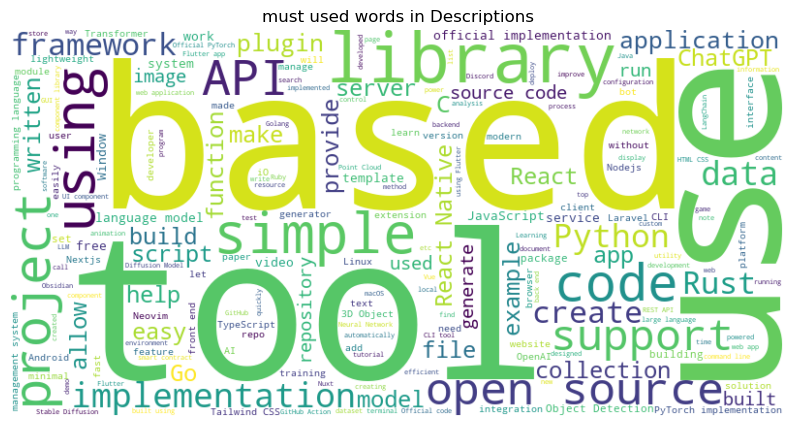

In [90]:
# Concatenate all descriptions into a single string
descriptions = ' '.join(df['description'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(descriptions)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('must used words in Descriptions')
plt.show()

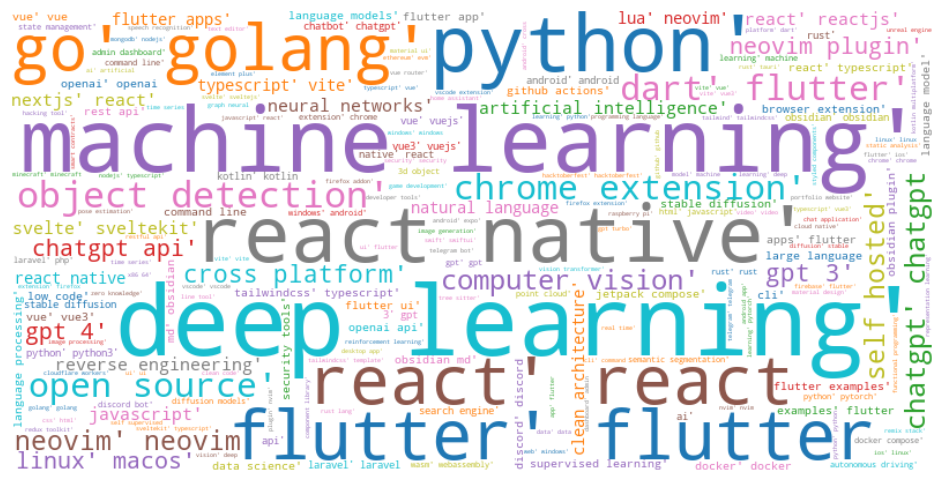

In [91]:
# Combine all topics into a single string, excluding the word "exclu"
all_topics = ' '.join([topic for topic in df['topics'].astype(str).tolist() if 'None' not in topic])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate(all_topics)

# Display the generated image
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [92]:
tfidf = TfidfVectorizer(stop_words='english')
doc_term_matrix = tfidf.fit_transform(df['topics'].values.astype('U'))
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(doc_term_matrix)
for index, topic in enumerate(lda.components_):
    print(f'Top 10 words for topic #{index}:')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['terraform', 'tool', 'tauri', 'cli', 'api', 'python', 'plugin', 'chatgpt', 'obsidian', 'rust']


Top 10 words for topic #1:
['dart', 'app', 'windows', 'native', 'android', 'react', 'hacktoberfest', 'ios', 'neovim', 'flutter']


Top 10 words for topic #2:
['object', 'models', 'vision', 'python', 'detection', 'machine', 'deep', 'pytorch', 'language', 'learning']


Top 10 words for topic #3:
['music', 'laravel', 'hosted', 'docker', 'typescript', 'tailwindcss', 'security', 'react', 'self', 'kubernetes']


Top 10 words for topic #4:


C:\Users\amine\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['tailwindcss', 'openai', 'nextjs', 'gpt', 'svelte', 'chatgpt', 'vue', 'javascript', 'react', 'typescript']




### recommandation

#### Utiliser des langages de programmation populaires et largement utilisés tels que Python et JavaScript Mettre en œuvre des workflows de développement qui incluent le suivi des problèmes, la gestion de projet et les wikis Se concentrer sur des sujets et des thèmes pertinents et importants pour le public cible du référentiel Collaborer avec d'autres développeurs et contributeurs pour améliorer la qualité et l'efficacité du code et de la documentation du référentiel.

In [93]:
df.to_csv('data_clean_befor_analysis.csv', index = False)